METHODS :
- Vanilla NN : we train a simple neural network on a single training set with no bias and we evaluate it on a biased test set.
- Preprocessing : we train a simple neural network on a single training set with no bias and we evaluate it on a preprocessed biased test set. We sequentialy apply scaling preprocessing, translation preprocessing and rotation preprocessing to the test set before evaluation(the reverse order in which biases were introduced).
- Data augmentation : to prevent from curse of dimensionality, when we augment a dataset, the augmented dataset has the same size as the initial dataset. We augment the training with respect to the translation bias (5 nuisance values), then we augment the resulting augmented set with respect to the rotation bias (5 nuisance values), then we augment the resulting augmented set with respect to the scaling bias. Then we train a simple neural network with the resulting augmented set and we evaluate it on the biased test set.
- Pivot : We assume to know the nuisance space (i.e. the carthesian product of the nuisance range of each nuisance kind). Here, to do as if this nuisance space was given, we compute the min and max value of each nuisance kind used in the test set. Then for each nuisance kind, we sample regularly a few nuisance values. Then we compute a carthesian product to have a lot of nuisance values combiantion that span the whole nuisance space and we generate a training set for each of these combinations. For example, if we have 2 nuisance kinds (rotation and scaling) and we sample 5 nuisance values for each of these nuisance kinds, we need to generate 32 training sets. Then we fit a pivot model on these training sets and we evaluate it on the test sets.
- DANN : we train a neural network with train points, train class labels, train domain label ("source" for each train sample), test points, test domain label ("target" for each test sample). The train set has no bias. Then we evaluate the trained model on the test set.
- Uncertainty aware : we generate training sets as done for the Pivot method. Then we train a neural network that takes both points coordinates and nuisance values as input and outputs the predicted class label. We evalute the trained model with a test set, providing explicitely its nuisance values. Apply in this way, this method can not be used to solve the challenge as contestants don't know the nuisance values of the test sets.

DATASETS :
- Datasets 1 : 12 datasets generated with several nuisance combinations. Each dataset is generated with Gaussian (independent marginals)
- Datasets 2 : 12 datasets generated with several nuisance combinations. Each dataset is generated with Gaussian (not independant marginals)
- Datasets 3 : 12 datesets generated with several nuisance combinations. Each dataset is generated with Gaussian (use of copulas for marginals).
    

# 0 - Imports

In [62]:
import importlib
import matplotlib
import matplotlib as mpl
import itertools
import json
import numpy as np
import os
import math
import pandas as pd
from sys import path
from copy import copy, deepcopy
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

In [2]:
path.append("ingestion_program/")
path.append("../Data_Generator")
path.append("DANN_program/")

# 1 - Load Data

In [3]:
from data_io import load_data, show_data_statistics, write

## 1.1 - All systematics normal Gaussian

In [4]:
data_dir = "DANN_data/quantitative/all_systematics_normal_gaussian"

In [5]:
train_sets_1, test_sets_1, settings_1 = load_data(data_dir, load_settings=True)



###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  DANN_data/quantitative/all_systematics_normal_gaussian
[*] train data dir :  DANN_data/quantitative/all_systematics_normal_gaussian\train\data
[*] train labels dir :  DANN_data/quantitative/all_systematics_normal_gaussian\train\labels
[*] test data dir :  DANN_data/quantitative/all_systematics_normal_gaussian\test\data
[*] test labels dir :  DANN_data/quantitative/all_systematics_normal_gaussian\test\labels
[*] settings dir :  DANN_data/quantitative/all_systematics_normal_gaussian\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 12 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------




## 1.2 - All systematics multivariate

In [6]:
data_dir = "DANN_data/quantitative/all_systematics_multivariate"

In [7]:
train_sets_2, test_sets_2, settings_2 = load_data(data_dir, load_settings=True)



###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  DANN_data/quantitative/all_systematics_multivariate
[*] train data dir :  DANN_data/quantitative/all_systematics_multivariate\train\data
[*] train labels dir :  DANN_data/quantitative/all_systematics_multivariate\train\labels
[*] test data dir :  DANN_data/quantitative/all_systematics_multivariate\test\data
[*] test labels dir :  DANN_data/quantitative/all_systematics_multivariate\test\labels
[*] settings dir :  DANN_data/quantitative/all_systematics_multivariate\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 12 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------




## 1.3 - All systematics normal Gamma copulas

In [8]:
data_dir = "DANN_data/quantitative/all_systematics_normal_gaussian_copulas"

In [9]:
train_sets_3, test_sets_3, settings_3 = load_data(data_dir, load_settings=True)



###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  DANN_data/quantitative/all_systematics_normal_gaussian_copulas
[*] train data dir :  DANN_data/quantitative/all_systematics_normal_gaussian_copulas\train\data
[*] train labels dir :  DANN_data/quantitative/all_systematics_normal_gaussian_copulas\train\labels
[*] test data dir :  DANN_data/quantitative/all_systematics_normal_gaussian_copulas\test\data
[*] test labels dir :  DANN_data/quantitative/all_systematics_normal_gaussian_copulas\test\labels
[*] settings dir :  DANN_data/quantitative/all_systematics_normal_gaussian_copulas\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 12 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------




In [10]:
train_sets = [train_sets_1,train_sets_2,train_sets_3]
test_sets = [test_sets_1,test_sets_2,test_sets_3]
settings = [settings_1,settings_2,settings_3]

# 2 - Define models

## Vanilla NN

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import keras

In [12]:
class balanced_accuracy(keras.metrics.SparseCategoricalAccuracy):
    def __init__(self, name='balanced_acc', dtype=None):
        super().__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_flat = y_true
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)

        cls_counts = tf.math.bincount(y_true_int)
        cls_counts = tf.math.reciprocal_no_nan(tf.cast(cls_counts, self.dtype))
        weight = tf.gather(cls_counts, y_true_int)
        return super().update_state(y_true, y_pred, sample_weight=weight)


In [13]:
class WeightedSparseCategoricalCrossentropy(tf.keras.losses.Loss):
    def __init__(self, weightage):
        super(WeightedSparseCategoricalCrossentropy, self).__init__()
        self.weightage = tf.convert_to_tensor(weightage, dtype=tf.float32)
        
    def call(self, y_true, y_pred):
        y_true = tf.squeeze(y_true, axis=-1)  # Remove the extra dimension
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.math.log(tf.clip_by_value(y_pred, 1e-10, 1.0 - 1e-10))
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        sample_weights = tf.gather(self.weightage, y_true)
        weighted_loss = tf.multiply(loss, sample_weights)
        return weighted_loss

In [14]:
class CallbacksHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        super(CallbacksHistory, self).__init__()
        self.source_evaluations = {"class_preds_balanced_acc" : [],
                                   "domain_preds_acc" : []}
        self.target_evaluations = {"val_class_preds_balanced_acc" : [],
                                   "val_domain_preds_acc" : []}

    def on_epoch_end(self, epoch, logs=None):
        self.source_evaluations["class_preds_balanced_acc"].append(logs['class_preds_balanced_acc'])
        self.source_evaluations["domain_preds_acc"].append(logs['domain_preds_acc'])
        self.target_evaluations["val_class_preds_balanced_acc"].append(logs['val_class_preds_balanced_acc'])
        self.target_evaluations["val_domain_preds_acc"].append(logs['val_domain_preds_acc'])


In [15]:
def train_NN (train_sets) :
    # Adapt data for NN
    x_train, y_train = train_sets[0]["data"].values, train_sets[0]["labels"]
    
    # Set parameters for NN
    num_epochs = 5
    batch_size = 100
    class_weights = [1,9]
    
    # Build NN
    inputs = Input(shape=(2,))
    hidden_1 = Dense(32, activation='tanh', name="h_1")(inputs)
    hidden_2 = Dense(32, activation='tanh', name="h_2")(hidden_1)
    hidden_3 = Dense(32, activation='tanh', name="h_3")(hidden_2)
    class_preds = Dense(2, activation='softmax', name="class_preds")(hidden_3)
    
    # Instantiate NN
    NN = Model(inputs = inputs, outputs = class_preds, name = "NN")
    
    # Compile NN
    balanced_crossentropy = WeightedSparseCategoricalCrossentropy(class_weights)

    NN.compile(optimizer = "adam",
               loss = balanced_crossentropy,
               metrics = balanced_accuracy())
    
    # Train NN
    NN.fit(x_train,
           y_train,
           batch_size,
           num_epochs,
           verbose=0)
    
    return NN

In [16]:
def test_NN (NN,test_sets) :
    x_test, y_test = test_sets[0]["data"].values, test_sets[0]["labels"]
    
    # Evaluate NN
    res_target = NN.evaluate(x_test,y_test)

    return res_target[1]

In [17]:
def call_NN (train_sets,test_sets) :
    NN = train_NN(train_sets)
    return test_NN (NN,test_sets)

## Preprocessing

In [18]:
def _preprocess_translation(train_set,test_set):
    train_mean = np.mean(train_set["data"])
    test_mean = np.mean(test_set["data"])
    translation = test_mean - train_mean
    translated_set = {
        "data" : test_set["data"] - translation, 
        "labels" : test_set["labels"]}
    return translated_set

In [19]:
def _preprocess_scaling(train_set,test_set):
    train_std = np.std(train_set["data"])
    test_std = np.std(test_set["data"])
    scaling = test_std/train_std
    scaled_set = {
        "data" : test_set["data"]/scaling, 
        "labels" : test_set["labels"]}
    return scaled_set

In [20]:
def get_direction(data_set):
    samples = data_set['data']
    b_mu = np.mean(samples[data_set['labels']==0], axis=0)
    s_mu = np.mean(samples[data_set['labels']==1], axis=0)
    direction = s_mu - b_mu
    data_angle = (math.atan2(direction[1], direction[0]))*180/np.pi
    return data_angle

def _preprocess_rotation(train_set, test_set):
    train_angle = get_direction(train_set)
    test_angle = get_direction(test_set)

    # Calculate rotation bias in degrees
    rotation_degree = test_angle - train_angle
    rotation_matrix = np.array([ [np.cos(rotation_degree) , -np.sin(rotation_degree)], [np.sin(rotation_degree), np.cos(rotation_degree)] ])
    rotated_data = pd.DataFrame(np.matmul(rotation_matrix, test_set["data"].T).T)
    rotated_data.columns = test_set['data'].columns
    rotated_dataset = {
        "data" : rotated_data, 
        "labels" : test_set["labels"]
    }
    return rotated_dataset


In [21]:
def call_preprocessing (train_sets,test_sets) :
    prepro_set = _preprocess_scaling(train_sets[0],test_sets[0])
    prepro_set = _preprocess_translation(prepro_set,test_sets[0])
    prepro_set = _preprocess_rotation(prepro_set,test_sets[0])
    
    return call_NN([train_sets[0]], [prepro_set])

## Data augmentation

In [22]:
from ingestion_program.augment_data import (get_augmented_data,
                                            get_augmented_data_rotation,
                                            get_augmented_data_scaling)

In [23]:
import matplotlib.pyplot as plt

In [24]:
def call_aug (train_sets,test_sets) :
    # Augment data
    aug_set = get_augmented_data(train_sets[0],test_sets[0])
    aug_set = get_augmented_data_rotation(aug_set,test_sets[0])
    aug_set = get_augmented_data_scaling(aug_set,test_sets[0])
    x_aug, y_aug = aug_set["data"].values, aug_set["labels"]
    
    #plt.scatter(x_aug[y_aug==0][:,0],x_aug[y_aug==0][:,1],c="b")
    #plt.scatter(x_aug[y_aug==1][:,0],x_aug[y_aug==1][:,1],c="r")
    #plt.show
    
    return call_NN ([aug_set],test_sets)

## PNN

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.metrics import balanced_accuracy_score as BA

In [26]:
@tf.custom_gradient
def grad_reverse(x, scale=1):
#def grad_reverse(x, scale=1.):
    y = tf.identity(x)
    def custom_grad(dy):
        # Since the decorated function `reverse_gradient()` actually has 2 inputs 
        # (counting `hp_lambda), we have to return the gradient for each -- but
        # anyway, the derivative w.r.t `hp_lambda` is null:
        print(scale)
        return -dy * scale, tf.constant(0.)
    return y, custom_grad

class GradReverseTR(tf.keras.layers.Layer):
    def __init__(self):
        super(GradReverseTR, self).__init__()
        #self.hp_lambda = hp_lambda

    def call(self, x, hp_lambda):
        return grad_reverse(x,hp_lambda)#,self.hp_lambda)
  

In [27]:
class OneDWeightedSparseCategoricalCrossentropy(tf.keras.losses.Loss):
    def __init__(self, weightage):
        super(OneDWeightedSparseCategoricalCrossentropy, self).__init__()
        self.weightage = tf.convert_to_tensor(weightage, dtype=tf.float32)
        
    def call(self, y_true, y_pred):
        y_true = tf.squeeze(y_true, axis=-1)  # Remove the extra dimension
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.concat((1-y_pred,y_pred), axis=1)
        y_pred = tf.math.log(tf.clip_by_value(y_pred, 1e-10, 1.0 - 1e-10))
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        sample_weights = tf.gather(self.weightage, y_true)
        weighted_loss = tf.multiply(loss, sample_weights)
        return weighted_loss

In [28]:
def train_PNN (x_train, y_train, z_train) :
    # Set parameters for PNN
    input_size = 2
    n_hidden_inv = 4; n_hidden_inv_R = 4
    n_nodes_inv = 32; n_nodes_inv_R = 32
    hp_lambda = 1.0
    n_epochs = 10
    batch_size = 500
    class_weights = [1,9]

    # Build PNN
    inputs = Input(shape=(input_size,))

    Dx = Dense(n_nodes_inv, activation="relu")(inputs)
    for i in range(n_hidden_inv -1):
        Dx = Dense(n_nodes_inv, activation='relu', kernel_regularizer='l2')(Dx)
    Dx = Dense(1, activation="sigmoid", name="Clf")(Dx)
    PNN = Model(inputs=inputs, outputs=Dx)

    GRx = GradReverseTR()(Dx,hp_lambda)
    Rx = Dense(n_nodes_inv_R, activation="relu")(GRx)
    for i in range(n_hidden_inv_R -1):
        Rx = Dense(n_nodes_inv_R, activation='relu', kernel_regularizer='l2')(Rx)
    #Rx = Dense(1, activation="sigmoid")(Rx)
    Rx = Dense(5, activation="sigmoid", name="Adv")(Rx)
    GR = Model(inputs=inputs, outputs=[Dx, Rx])
    
    # Compile PNN
    balanced_crossentropy = OneDWeightedSparseCategoricalCrossentropy(class_weights)
    
    GR.compile(optimizer="RMSProp",
               loss=[balanced_crossentropy, "mean_squared_error"], 
               loss_weights=[1,hp_lambda],
               metrics = ["accuracy",None])
    
    # Fit PNN
    GR.fit(x=x_train,
           y=[y_train, z_train],
           epochs=n_epochs,
           batch_size=batch_size,
           verbose=0)
    
    return PNN

In [29]:
def test_PNN (PNN,test_set) :
    x_test, y_test = test_set["data"].values, test_set["labels"]
    
    # Evaluate PNN
    y_pred = np.round(np.reshape(PNN.predict(x_test),(-1,)),0).astype(int).reshape((-1,1))
    results = BA(y_test,y_pred)
    
    return results

## DANN

In [30]:
from DANN import set_data_for_DANN,build_datasets_for_DANN
from DANN import (build_DANN,
                  compile_DANN,
                  fit_DANN,
                  evaluate_DANN)

In [31]:
def call_DANN (train_sets,test_sets) :
    # Set parameters for DANN
    input_size  = (2,)
    hp_lambda = 2.0
    num_epochs  = 20
    batch_size  = 20
    class_weights = [1,9]
    nums_source_samples = [train_set["labels"].shape[0] for train_set in train_sets]
    nums_target_samples = [test_set["labels"].shape[0] for test_set in test_sets]
    nums_train_steps_per_epoch = [math.ceil((num_source_samples+num_target_samples)/batch_size) for num_source_samples,num_target_samples in zip(nums_source_samples,nums_target_samples)]
    nums_test_steps_per_epoch = [math.ceil(num_target_samples/batch_size) for num_target_samples in nums_target_samples]
    
    # Prepare data for DANN
    x_sources, y_sources, x_targets, y_targets = set_data_for_DANN (train_sets,test_sets)
    training_datasets, testing_datasets = build_datasets_for_DANN (x_sources,y_sources,x_targets,y_targets,num_epochs, int(0.5*batch_size), portion_of_target_for_train=1)
    
    # Use DANN
    models = []
    histories = []
    for i,data_pack in enumerate(zip(training_datasets,testing_datasets,nums_train_steps_per_epoch,nums_test_steps_per_epoch)):

        # Unpack
        training_dataset,testing_dataset,num_train_steps_per_epoch,num_test_steps_per_epoch = data_pack

        # Build DANN
        DANN_model = build_DANN("DANN_"+str(i+1),input_size,hp_lambda)
        print("Started to work with", DANN_model.name)

        # Compile DANN
        compile_DANN(DANN_model,class_weights)

        # Fit DANN
        history = fit_DANN(DANN_model,training_dataset,testing_dataset,num_epochs,num_train_steps_per_epoch,num_test_steps_per_epoch)
        models.append(DANN_model)
        histories.append(history)
    
    # Evaluate DANN
    results = evaluate_DANN(models[0],x_sources[0], y_sources[0], x_targets[0], y_targets[0])
    return float(results["target_bal_acc"])

## Uncertainty aware

In [32]:
from data_loader import get_settings_from_json
from data_generator_all_systematics import DataGenerator

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Lambda, Multiply, Add, Concatenate, Dense
from tensorflow.keras.models import Model

In [33]:
def get_unique_nuisance_values (settings) :
    systematics_values = {"z_magnitudes" : [],
                          "alphas" : [],
                          "scaling_factors" : [],
                          "box_ls" : [],
                          "rotation_degrees" : []}
    for setting in settings :
        systematics_values["z_magnitudes"].append(setting["systematics"][0]["z_magnitude"])
        systematics_values["alphas"].append(setting["systematics"][0]["alpha"])
        systematics_values["scaling_factors"].append(setting["systematics"][1]["scaling_factor"])
        systematics_values["box_ls"].append(setting["systematics"][2]["box_l"])
        systematics_values["rotation_degrees"].append(setting["systematics"][3]["rotation_degree"])
    return {key: list(set(value)) for key, value in systematics_values.items()}

In [34]:
def generate_discrete_coverage_training_sets(dict_uniques,settings,datasets_number) :
    cartesian_product = list(itertools.product(dict_uniques["z_magnitudes"],
                                               dict_uniques["alphas"],
                                               dict_uniques["scaling_factors"],
                                               dict_uniques["box_ls"],
                                               dict_uniques["rotation_degrees"]))
    data_dir = "DANN_data/quantitative/datasets_{}".format(datasets_number)
    setting_archetype = settings[0]
    for index,nuisance_values in enumerate(cartesian_product) :
        setting_archetype["systematics"][0]["z_magnitude"] = nuisance_values[0]
        setting_archetype["systematics"][0]["alpha"] = nuisance_values[1]
        setting_archetype["systematics"][1]["scaling_factor"] = nuisance_values[2]
        setting_archetype["systematics"][2]["box_l"] = nuisance_values[3]
        setting_archetype["systematics"][3]["rotation_degree"] = nuisance_values[4]
        
        data_gen = DataGenerator(settings_dict=setting_archetype)
        data_gen.generate_data()
        data_gen.save_data(directory=data_dir, file_index=index+1)
    
    #return cartesian_product

In [35]:
def prepare_training_data_for_aware_model(datasets_number) :
    data_dir = "DANN_data/quantitative/datasets_{}".format(datasets_number)
    _, aware_train_sets, aware_settings = load_data(data_dir, load_settings=True)
    x_train,y_train,z_train = [],[],[]
    for aware_train_set, aware_setting in zip(aware_train_sets, aware_settings) :
        x_train += aware_train_set["data"].values.tolist()
        y_train += list(aware_train_set["labels"])
        nb_events = len(aware_train_set["data"].values.tolist())
        z_train += [[aware_setting["systematics"][0]["z_magnitude"],
                     aware_setting["systematics"][0]["alpha"],
                     aware_setting["systematics"][1]["scaling_factor"],
                     aware_setting["systematics"][2]["box_l"],
                     aware_setting["systematics"][3]["rotation_degree"]] for i in range(nb_events)]
    return np.array(x_train),np.array(y_train),np.array(z_train)

In [36]:
def model_up_and_down (input_shapes) :
    n_hidden_awe = 10
    n_nodes_awe = 64
    class_weights = [1,9]

    inputs_x = Input(shape=input_shapes[0])
    inputs_z = Input(shape=input_shapes[1])
    inputs = Concatenate(axis=-1)([inputs_x, inputs_z])

    netAweUp = Dense(n_nodes_awe, activation="relu")(inputs)
    for i in range(n_hidden_awe -1):
        netAweUp = Dense(n_nodes_awe, activation='relu', kernel_regularizer='l2')(netAweUp)
    predictions_netAweUp = Dense(1, activation='sigmoid')(netAweUp)

    netAweUp_model = Model(inputs=[inputs_x, inputs_z], outputs=predictions_netAweUp)
    balanced_crossentropy = OneDWeightedSparseCategoricalCrossentropy(class_weights)
    netAweUp_model.compile(optimizer='RMSProp',
                  loss='binary_crossentropy',
                  metrics=balanced_accuracy()) # ['accuracy'])

    netAweDown = Dense(n_nodes_awe, activation="relu")(inputs)
    for i in range(n_hidden_awe -1):
        netAweDown = Dense(n_nodes_awe, activation='relu', kernel_regularizer='l2')(netAweDown)
    predictions_netAweDown = Dense(1, activation='sigmoid')(netAweDown)

    netAweDown_model = Model(inputs=[inputs_x, inputs_z], outputs=predictions_netAweDown)
    balanced_crossentropy_bis = WeightedSparseCategoricalCrossentropy(class_weights)
    netAweDown_model.compile(optimizer='RMSProp',
                  loss=balanced_crossentropy_bis, # 'binary_crossentropy',
                  metrics=balanced_accuracy()) # ['accuracy'])
    return netAweUp_model, netAweDown_model

In [37]:
def combineModels(ModelUp, ModelDown, input_shapes):
    input1 = Input(shape=input_shapes[0])
    input2 = Input(shape=input_shapes[1])

    selectModel1 = Lambda(lambda x: K.greater_equal(x, K.constant(1.)))(input2)
    selectModel2 = Lambda(lambda x: K.less(x, K.constant(1.)))(input2)

    selectModel1 = Lambda(lambda x: K.cast(x, dtype='float32'))(selectModel1)
    selectModel2 = Lambda(lambda x: K.cast(x, dtype='float32'))(selectModel2)

    out1 = Multiply()([ModelUp([input1,input2]), selectModel1])
    out2 = Multiply()([ModelDown([input1,input2]), selectModel2])
    
    out  = Add()([out1, out2])
    model = Model(inputs=[input1,input2], outputs=out)
    return model

In [38]:
def train_aware(settings, datasets_number) :
    # Prepare training data
    dict_uniques = get_unique_nuisance_values (settings)
    generate_discrete_coverage_training_sets(dict_uniques,settings,datasets_number)
    X_syst_train,Y_syst_train,Z_syst_train = prepare_training_data_for_aware_model(datasets_number)
    
    indices = np.arange(X_syst_train.shape[0])
    np.random.shuffle(indices)
    
    X_syst_train,Y_syst_train,Z_syst_train = X_syst_train[indices],Y_syst_train[indices],Z_syst_train[indices]
    
    # Set parameters for aware model
    input_shapes = [(X_syst_train.shape[1],),(Z_syst_train.shape[1],)]
    epochs = 10
    batch_size = 64
    class_weights = [1,9]
    
    # Define up and down models
    model_up, model_down = model_up_and_down(input_shapes)
    
    # Combine models
    aware_model = combineModels(model_up, model_down, input_shapes)
        
    balanced_crossentropy = WeightedSparseCategoricalCrossentropy(class_weights)
    aware_model.compile(optimizer='RMSProp',
                  loss=balanced_crossentropy,# 'binary_crossentropy',
                  metrics=balanced_accuracy())# ['accuracy'])
    
    # Train combined model
    aware_model.fit(x=[X_syst_train, Z_syst_train], 
                    y=Y_syst_train,                                   # sample_weight=weights_train, 
                    epochs=epochs, batch_size=batch_size)
    
    return aware_model

In [39]:
def test_aware (aware_model,test_sets,settings) :
    x_test, y_test = test_sets[0]["data"].values, test_sets[0]["labels"]
    
    # Evaluate NN
    z_test = np.vstack([[settings["systematics"][0]["z_magnitude"],
                     settings["systematics"][0]["alpha"],
                     settings["systematics"][1]["scaling_factor"],
                     settings["systematics"][2]["box_l"],
                     settings["systematics"][3]["rotation_degree"]]] * x_test.shape[0])
    res_target = aware_model.evaluate([x_test,z_test],y_test)
    return res_target[1]

# 3 - Use models

## Vanilla NN

In [40]:
def run_NN (outputs_list) :
    VNN_outputs = []
    for train_sets_j, test_sets_j in zip(train_sets,test_sets) :
        outputs_j = []
        NN = train_NN([train_sets_j[0]])
        for i in range(12) :
            outputs_j.append(test_NN(NN,[test_sets_j[i]]))
        VNN_outputs.append(outputs_j)
    outputs_list.append(VNN_outputs)
    return outputs_list

## Preprocessing

In [41]:
def run_prepro (outputs_list) :
    preprocessing_outputs = []
    for train_sets_j, test_sets_j in zip(train_sets,test_sets) :
        outputs_j = []
        for i in range(12) :
            outputs_j.append(call_preprocessing([train_sets_j[i]],[test_sets_j[i]]))
        preprocessing_outputs.append(outputs_j)
    outputs_list.append(preprocessing_outputs)
    return outputs_list

## Data augmentation

In [42]:
def run_aug (outputs_list) :
    aug_outputs = []
    for train_sets_j, test_sets_j in zip(train_sets,test_sets) :
        outputs_j = []
        for i in range(12) :
            outputs_j.append(call_aug([train_sets_j[i]],[test_sets_j[i]]))
        aug_outputs.append(outputs_j)
    outputs_list.append(aug_outputs)
    return outputs_list

## PNN

In [43]:
def run_PNN (outputs_list) :
    PNN_outputs = []
    for j, train_sets_j, test_sets_j, settings_j in zip(range(3),train_sets,test_sets,settings) :
        dict_uniques = get_unique_nuisance_values(settings_j)
        generate_discrete_coverage_training_sets(dict_uniques,settings_j,j)
        X_syst_train,Y_syst_train,Z_syst_train = prepare_training_data_for_aware_model(j)
        PNN = train_PNN(X_syst_train, Y_syst_train, Z_syst_train)
        outputs_j = []
        for i in range(12) :
            test_set_j_i = test_sets_j[i]
            outputs_j.append(test_PNN(PNN,test_set_j_i))
        PNN_outputs.append(outputs_j)
    outputs_list.append(PNN_outputs)
    return outputs_list

## DANN

In [44]:
def run_DANN (outputs_list) :
    DANN_outputs = []
    for train_sets_j, test_sets_j in zip(train_sets,test_sets) :
        outputs_j = []
        for i in range(12) :
            outputs_j.append(call_DANN([train_sets_j[i]],[test_sets_j[i]]))
        DANN_outputs.append(outputs_j)
    outputs_list.append(DANN_outputs)
    return outputs_list

## Uncertainty aware

In [45]:
def run_aware (outputs_list) :
    aware_outputs = []
    for j,train_sets_j, test_sets_j, settings_j in zip(range(3),train_sets,test_sets,settings):
        outputs_j = []
        aware_model = train_aware(settings_j,j)
        for i in range(12) :
            outputs_j.append(test_aware(aware_model,[test_sets_j[i]],settings_j[i]))
        aware_outputs.append(outputs_j)
    outputs_list.append(aware_outputs)
    return outputs_list

In [46]:
nb_run = 5
methods_to_run = [run_NN, run_prepro, run_aug, run_PNN, run_DANN, run_aware]

In [47]:
runs_list = []
for run in range(nb_run) :
    outputs_list = []
    for method in methods_to_run :
        outputs_list = method(outputs_list)
    runs_list.append(outputs_list)

40/40 [==============================] - 0s 1ms/step - loss: 1.0840 - balanced_acc: 0.7521


21/21 [==============================] - 0s 2ms/step - loss: nan - balanced_acc: 1.0000


###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  DANN_data/quantitative/datasets_0
[*] train data dir :  DANN_data/quantitative/datasets_0\train\data
[*] train labels dir :  DANN_data/quantitative/datasets_0\train\labels
[*] test data dir :  DANN_data/quantitative/datasets_0\test\data
[*] test labels dir :  DANN_data/quantitative/datasets_0\test\labels
[*] settings dir :  DANN_data/quantitative/datasets_0\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 36 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------


Tensor("model_1/grad_reverse_tr/Const:0", shape=(), dtype=float32)
Tensor("model_1/grad_reverse_tr/Const:0", shape=(), dtype=float32)
56/56 [==================

46/46 [==============================] - 0s 3ms/step - loss: 0.9852 - class_preds_loss: 0.4072 - domain_preds_loss: 0.5780 - class_preds_acc: 0.9162 - class_preds_balanced_acc: 0.9211 - domain_preds_acc: 0.9237
Started to work with DANN_1
46/46 [==============================] - 0s 2ms/step - loss: 1.6199 - class_preds_loss: 0.9785 - domain_preds_loss: 0.6414 - class_preds_acc: 0.8762 - class_preds_balanced_acc: 0.8647 - domain_preds_acc: 0.8000
Started to work with DANN_1
35/35 [==============================] - 0s 2ms/step - loss: 2.5506 - class_preds_loss: 1.8950 - domain_preds_loss: 0.6557 - class_preds_acc: 0.8939 - class_preds_balanced_acc: 0.8030 - domain_preds_acc: 0.5122
Started to work with DANN_1
35/35 [==============================] - 0s 2ms/step - loss: 14.1680 - class_preds_loss: 13.5469 - domain_preds_loss: 0.6211 - class_preds_acc: 0.8051 - class_preds_balanced_acc: 0.5081 - domain_preds_acc: 0.6155
Started to work with DANN_1
47/47 [==============================] - 0

45/45 [==============================] - 0s 2ms/step - loss: 1.6447 - class_preds_loss: 1.0557 - domain_preds_loss: 0.5890 - class_preds_acc: 0.6146 - class_preds_balanced_acc: 0.7339 - domain_preds_acc: 0.5979
Started to work with DANN_1
48/48 [==============================] - 0s 1ms/step - loss: 2.0456 - class_preds_loss: 1.4350 - domain_preds_loss: 0.6106 - class_preds_acc: 0.5730 - class_preds_balanced_acc: 0.6970 - domain_preds_acc: 0.6315
Started to work with DANN_1
63/63 [==============================] - 0s 2ms/step - loss: 3.1763 - class_preds_loss: 2.4661 - domain_preds_loss: 0.7101 - class_preds_acc: 0.8645 - class_preds_balanced_acc: 0.6084 - domain_preds_acc: 0.4655
Started to work with DANN_1
63/63 [==============================] - 0s 2ms/step - loss: 0.9656 - class_preds_loss: 0.4063 - domain_preds_loss: 0.5593 - class_preds_acc: 0.8785 - class_preds_balanced_acc: 0.9307 - domain_preds_acc: 0.6840
Started to work with DANN_1
48/48 [==============================] - 0s 

56/56 [==============================] - 0s 2ms/step - loss: 2.7276 - balanced_acc: 0.5088


###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  DANN_data/quantitative/datasets_1
[*] train data dir :  DANN_data/quantitative/datasets_1\train\data
[*] train labels dir :  DANN_data/quantitative/datasets_1\train\labels
[*] test data dir :  DANN_data/quantitative/datasets_1\test\data
[*] test labels dir :  DANN_data/quantitative/datasets_1\test\labels
[*] settings dir :  DANN_data/quantitative/datasets_1\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 72 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------


Epoch 1/10
1901/1901 [==============================] - 10s 4ms/step - loss: 3.2796 - balanced_acc: 0.5223
Epoch 2/10
1901/1901 [===========================

63/63 [==============================] - 0s 1ms/step - loss: 1.4128 - balanced_acc: 0.4072


21/21 [==============================] - 0s 2ms/step - loss: nan - balanced_acc: 1.0000


###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  DANN_data/quantitative/datasets_0
[*] train data dir :  DANN_data/quantitative/datasets_0\train\data
[*] train labels dir :  DANN_data/quantitative/datasets_0\train\labels
[*] test data dir :  DANN_data/quantitative/datasets_0\test\data
[*] test labels dir :  DANN_data/quantitative/datasets_0\test\labels
[*] settings dir :  DANN_data/quantitative/datasets_0\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 36 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------


Tensor("model_16/grad_reverse_tr_3/Const:0", shape=(), dtype=float32)
Tensor("model_16/grad_reverse_tr_3/Const:0", shape=(), dtype=float32)
56/56 [============

35/35 [==============================] - 0s 2ms/step - loss: 14.3518 - class_preds_loss: 13.7809 - domain_preds_loss: 0.5708 - class_preds_acc: 0.7987 - class_preds_balanced_acc: 0.5044 - domain_preds_acc: 0.6733
Started to work with DANN_1
47/47 [==============================] - 0s 2ms/step - loss: 1.0220 - class_preds_loss: 0.3925 - domain_preds_loss: 0.6295 - class_preds_acc: 0.8942 - class_preds_balanced_acc: 0.9297 - domain_preds_acc: 0.8278
Started to work with DANN_1
46/46 [==============================] - 0s 2ms/step - loss: 2.1807 - class_preds_loss: 1.5054 - domain_preds_loss: 0.6752 - class_preds_acc: 0.8598 - class_preds_balanced_acc: 0.7752 - domain_preds_acc: 0.5069
Started to work with DANN_1
56/56 [==============================] - 0s 2ms/step - loss: 1.2886 - class_preds_loss: 0.6339 - domain_preds_loss: 0.6548 - class_preds_acc: 0.7957 - class_preds_balanced_acc: 0.8851 - domain_preds_acc: 0.8636
Started to work with DANN_1
56/56 [==============================] - 0

63/63 [==============================] - 0s 3ms/step - loss: 0.8033 - class_preds_loss: 0.2615 - domain_preds_loss: 0.5419 - class_preds_acc: 0.9205 - class_preds_balanced_acc: 0.9476 - domain_preds_acc: 0.6935
Started to work with DANN_1
48/48 [==============================] - 0s 2ms/step - loss: 1.1304 - class_preds_loss: 0.4212 - domain_preds_loss: 0.7091 - class_preds_acc: 0.8278 - class_preds_balanced_acc: 0.9010 - domain_preds_acc: 0.3824
Started to work with DANN_1
63/63 [==============================] - 0s 1ms/step - loss: 15.0933 - class_preds_loss: 14.7777 - domain_preds_loss: 0.3156 - class_preds_acc: 0.9000 - class_preds_balanced_acc: 0.5081 - domain_preds_acc: 0.8810
Started to work with DANN_1
63/63 [==============================] - 0s 1ms/step - loss: 1.1939 - class_preds_loss: 0.6914 - domain_preds_loss: 0.5025 - class_preds_acc: 0.8265 - class_preds_balanced_acc: 0.8978 - domain_preds_acc: 0.7370
Started to work with DANN_1
47/47 [==============================] - 0

---------------------------------
[+] Train and Test data loaded!
---------------------------------


Epoch 1/10
1904/1904 [==============================] - 7s 3ms/step - loss: 3.2473 - balanced_acc: 0.5693
Epoch 2/10
1904/1904 [==============================] - 7s 4ms/step - loss: 2.6576 - balanced_acc: 0.6360
Epoch 3/10
1904/1904 [==============================] - 8s 4ms/step - loss: 2.6181 - balanced_acc: 0.6401
Epoch 4/10
1904/1904 [==============================] - 8s 4ms/step - loss: 2.5951 - balanced_acc: 0.6445
Epoch 5/10
1904/1904 [==============================] - 8s 4ms/step - loss: 2.5780 - balanced_acc: 0.6531
Epoch 6/10
1904/1904 [==============================] - 8s 4ms/step - loss: 2.5685 - balanced_acc: 0.6538
Epoch 7/10
1904/1904 [==============================] - 9s 5ms/step - loss: 2.5593 - balanced_acc: 0.6545
Epoch 8/10
1904/1904 [==============================] - 8s 4ms/step - loss: 2.5522 - balanced_acc: 0.6551
Epoch 9/10
1904/1904 [============================

21/21 [==============================] - 0s 1ms/step - loss: nan - balanced_acc: 1.0000


###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  DANN_data/quantitative/datasets_0
[*] train data dir :  DANN_data/quantitative/datasets_0\train\data
[*] train labels dir :  DANN_data/quantitative/datasets_0\train\labels
[*] test data dir :  DANN_data/quantitative/datasets_0\test\data
[*] test labels dir :  DANN_data/quantitative/datasets_0\test\labels
[*] settings dir :  DANN_data/quantitative/datasets_0\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 36 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------


Tensor("model_31/grad_reverse_tr_6/Const:0", shape=(), dtype=float32)
Tensor("model_31/grad_reverse_tr_6/Const:0", shape=(), dtype=float32)
47/47 [============

56/56 [==============================] - 0s 895us/step


###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  DANN_data/quantitative/datasets_1
[*] train data dir :  DANN_data/quantitative/datasets_1\train\data
[*] train labels dir :  DANN_data/quantitative/datasets_1\train\labels
[*] test data dir :  DANN_data/quantitative/datasets_1\test\data
[*] test labels dir :  DANN_data/quantitative/datasets_1\test\labels
[*] settings dir :  DANN_data/quantitative/datasets_1\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 72 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------


Tensor("model_33/grad_reverse_tr_7/Const:0", shape=(), dtype=float32)
Tensor("model_33/grad_reverse_tr_7/Const:0", shape=(), dtype=float32)
48/48 [==============================] - 0s 1ms/step

56/56 [==============================] - 0s 1ms/step - loss: 1.5271 - class_preds_loss: 0.9611 - domain_preds_loss: 0.5661 - class_preds_acc: 0.8003 - class_preds_balanced_acc: 0.8394 - domain_preds_acc: 0.6499
Started to work with DANN_1
63/63 [==============================] - 0s 1ms/step - loss: 1.5172 - class_preds_loss: 0.9159 - domain_preds_loss: 0.6013 - class_preds_acc: 0.8700 - class_preds_balanced_acc: 0.7580 - domain_preds_acc: 0.6800
Started to work with DANN_1
63/63 [==============================] - 0s 3ms/step - loss: 3.2136 - class_preds_loss: 2.5656 - domain_preds_loss: 0.6479 - class_preds_acc: 0.8055 - class_preds_balanced_acc: 0.4552 - domain_preds_acc: 0.5445
Started to work with DANN_1
43/43 [==============================] - 0s 2ms/step - loss: 1.4934 - class_preds_loss: 0.8378 - domain_preds_loss: 0.6555 - class_preds_acc: 0.8156 - class_preds_balanced_acc: 0.8261 - domain_preds_acc: 0.5378
Started to work with DANN_1
47/47 [==============================] - 0s 

47/47 [==============================] - 0s 977us/step - loss: 1.2497 - class_preds_loss: 0.6405 - domain_preds_loss: 0.6091 - class_preds_acc: 0.7792 - class_preds_balanced_acc: 0.8662 - domain_preds_acc: 0.7407
Started to work with DANN_1
63/63 [==============================] - 0s 2ms/step - loss: 18.8993 - class_preds_loss: 18.5163 - domain_preds_loss: 0.3830 - class_preds_acc: 0.8940 - class_preds_balanced_acc: 0.5047 - domain_preds_acc: 0.8525
Started to work with DANN_1
48/48 [==============================] - 0s 2ms/step - loss: 1.2053 - class_preds_loss: 0.5356 - domain_preds_loss: 0.6697 - class_preds_acc: 0.8362 - class_preds_balanced_acc: 0.9061 - domain_preds_acc: 0.6088
Started to work with DANN_1
63/63 [==============================] - 0s 2ms/step - loss: 20.9575 - class_preds_loss: 20.7233 - domain_preds_loss: 0.2342 - class_preds_acc: 0.9000 - class_preds_balanced_acc: 0.5081 - domain_preds_acc: 0.9010
Started to work with DANN_1
55/55 [==============================]

48/48 [==============================] - 0s 2ms/step - loss: 2.8641 - balanced_acc: 0.5053


###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  DANN_data/quantitative/datasets_2
[*] train data dir :  DANN_data/quantitative/datasets_2\train\data
[*] train labels dir :  DANN_data/quantitative/datasets_2\train\labels
[*] test data dir :  DANN_data/quantitative/datasets_2\test\data
[*] test labels dir :  DANN_data/quantitative/datasets_2\test\labels
[*] settings dir :  DANN_data/quantitative/datasets_2\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 80 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------


Epoch 1/10
1850/1850 [==============================] - 7s 2ms/step - loss: 3.2911 - balanced_acc: 0.5495
Epoch 2/10
1850/1850 [============================

21/21 [==============================] - 0s 3ms/step - loss: nan - balanced_acc: 1.0000


###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  DANN_data/quantitative/datasets_0
[*] train data dir :  DANN_data/quantitative/datasets_0\train\data
[*] train labels dir :  DANN_data/quantitative/datasets_0\train\labels
[*] test data dir :  DANN_data/quantitative/datasets_0\test\data
[*] test labels dir :  DANN_data/quantitative/datasets_0\test\labels
[*] settings dir :  DANN_data/quantitative/datasets_0\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 36 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------


Tensor("model_46/grad_reverse_tr_9/Const:0", shape=(), dtype=float32)
Tensor("model_46/grad_reverse_tr_9/Const:0", shape=(), dtype=float32)
56/56 [============

48/48 [==============================] - 0s 1ms/step


###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  DANN_data/quantitative/datasets_2
[*] train data dir :  DANN_data/quantitative/datasets_2\train\data
[*] train labels dir :  DANN_data/quantitative/datasets_2\train\labels
[*] test data dir :  DANN_data/quantitative/datasets_2\test\data
[*] test labels dir :  DANN_data/quantitative/datasets_2\test\labels
[*] settings dir :  DANN_data/quantitative/datasets_2\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 80 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------


Tensor("model_50/grad_reverse_tr_11/Const:0", shape=(), dtype=float32)
Tensor("model_50/grad_reverse_tr_11/Const:0", shape=(), dtype=float32)
21/21 [==============================] - 0s 1ms/step

43/43 [==============================] - 0s 2ms/step - loss: 1.4796 - class_preds_loss: 0.8068 - domain_preds_loss: 0.6728 - class_preds_acc: 0.7704 - class_preds_balanced_acc: 0.8198 - domain_preds_acc: 0.4978
Started to work with DANN_1
47/47 [==============================] - 0s 2ms/step - loss: 6.2418 - class_preds_loss: 5.6109 - domain_preds_loss: 0.6309 - class_preds_acc: 0.6078 - class_preds_balanced_acc: 0.5242 - domain_preds_acc: 0.6714
Started to work with DANN_1
36/36 [==============================] - 0s 1ms/step - loss: 1.5407 - class_preds_loss: 0.9361 - domain_preds_loss: 0.6046 - class_preds_acc: 0.7696 - class_preds_balanced_acc: 0.7738 - domain_preds_acc: 0.6396
Started to work with DANN_1
40/40 [==============================] - 0s 3ms/step - loss: 2.6586 - class_preds_loss: 2.0241 - domain_preds_loss: 0.6345 - class_preds_acc: 0.6910 - class_preds_balanced_acc: 0.6686 - domain_preds_acc: 0.6431
Started to work with DANN_1
30/30 [==============================] - 1s 

63/63 [==============================] - 0s 2ms/step - loss: 20.9539 - class_preds_loss: 20.7233 - domain_preds_loss: 0.2306 - class_preds_acc: 0.9000 - class_preds_balanced_acc: 0.5081 - domain_preds_acc: 0.9010
Started to work with DANN_1
55/55 [==============================] - 0s 2ms/step - loss: 10.7806 - class_preds_loss: 10.2213 - domain_preds_loss: 0.5592 - class_preds_acc: 0.8017 - class_preds_balanced_acc: 0.4608 - domain_preds_acc: 0.5886
Started to work with DANN_1
63/63 [==============================] - 0s 2ms/step - loss: 20.8174 - class_preds_loss: 20.3819 - domain_preds_loss: 0.4355 - class_preds_acc: 0.8900 - class_preds_balanced_acc: 0.5024 - domain_preds_acc: 0.8010
Started to work with DANN_1
21/21 [==============================] - 0s 2ms/step - loss: 0.5259 - class_preds_loss: 0.0874 - domain_preds_loss: 0.4385 - class_preds_acc: 0.9785 - class_preds_balanced_acc: 0.9792 - domain_preds_acc: 0.8543


###-------------------------------------###
### Data Loading
###

---------------------------------
[+] Train and Test data loaded!
---------------------------------


Epoch 1/10
1851/1851 [==============================] - 10s 3ms/step - loss: 3.3005 - balanced_acc: 0.5402
Epoch 2/10
1851/1851 [==============================] - 7s 4ms/step - loss: 2.7266 - balanced_acc: 0.6315
Epoch 3/10
1851/1851 [==============================] - 8s 4ms/step - loss: 2.6509 - balanced_acc: 0.6577
Epoch 4/10
1851/1851 [==============================] - 7s 4ms/step - loss: 2.5924 - balanced_acc: 0.6778
Epoch 5/10
1851/1851 [==============================] - 7s 4ms/step - loss: 2.5405 - balanced_acc: 0.6936
Epoch 6/10
1851/1851 [==============================] - 7s 4ms/step - loss: 2.5089 - balanced_acc: 0.7021
Epoch 7/10
1851/1851 [==============================] - 7s 4ms/step - loss: 2.4893 - balanced_acc: 0.7042
Epoch 8/10
1851/1851 [==============================] - 7s 4ms/step - loss: 2.4770 - balanced_acc: 0.7081
Epoch 9/10
1851/1851 [===========================

21/21 [==============================] - 0s 2ms/step - loss: nan - balanced_acc: 1.0000


###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  DANN_data/quantitative/datasets_0
[*] train data dir :  DANN_data/quantitative/datasets_0\train\data
[*] train labels dir :  DANN_data/quantitative/datasets_0\train\labels
[*] test data dir :  DANN_data/quantitative/datasets_0\test\data
[*] test labels dir :  DANN_data/quantitative/datasets_0\test\labels
[*] settings dir :  DANN_data/quantitative/datasets_0\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 36 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------


Tensor("model_61/grad_reverse_tr_12/Const:0", shape=(), dtype=float32)
Tensor("model_61/grad_reverse_tr_12/Const:0", shape=(), dtype=float32)
56/56 [==========

21/21 [==============================] - 0s 2ms/step
Started to work with DANN_1
53/53 [==============================] - 0s 2ms/step - loss: 0.9988 - class_preds_loss: 0.3978 - domain_preds_loss: 0.6010 - class_preds_acc: 0.9310 - class_preds_balanced_acc: 0.9353 - domain_preds_acc: 0.8764
Started to work with DANN_1
42/42 [==============================] - 0s 2ms/step - loss: 5.5826 - class_preds_loss: 5.0303 - domain_preds_loss: 0.5523 - class_preds_acc: 0.8583 - class_preds_balanced_acc: 0.4865 - domain_preds_acc: 0.6674
Started to work with DANN_1
49/49 [==============================] - 0s 2ms/step - loss: 0.9827 - class_preds_loss: 0.3310 - domain_preds_loss: 0.6517 - class_preds_acc: 0.8941 - class_preds_balanced_acc: 0.9388 - domain_preds_acc: 0.5000
Started to work with DANN_1
54/54 [==============================] - 0s 2ms/step - loss: 17.7292 - class_preds_loss: 17.0566 - domain_preds_loss: 0.6726 - class_preds_acc: 0.8339 - class_preds_balanced_acc: 0.4760 - domain_preds_a

40/40 [==============================] - 0s 2ms/step - loss: 2.7328 - class_preds_loss: 2.0860 - domain_preds_loss: 0.6468 - class_preds_acc: 0.6714 - class_preds_balanced_acc: 0.6491 - domain_preds_acc: 0.6203
Started to work with DANN_1
30/30 [==============================] - 1s 2ms/step - loss: 2.6502 - class_preds_loss: 2.0021 - domain_preds_loss: 0.6481 - class_preds_acc: 0.8315 - class_preds_balanced_acc: 0.7419 - domain_preds_acc: 0.6094
Started to work with DANN_1
33/33 [==============================] - 0s 2ms/step - loss: 8.9852 - class_preds_loss: 8.3341 - domain_preds_loss: 0.6511 - class_preds_acc: 0.6260 - class_preds_balanced_acc: 0.4966 - domain_preds_acc: 0.5625
Started to work with DANN_1
36/36 [==============================] - 0s 3ms/step - loss: 2.7255 - class_preds_loss: 2.1048 - domain_preds_loss: 0.6207 - class_preds_acc: 0.7656 - class_preds_balanced_acc: 0.6113 - domain_preds_acc: 0.6084
Started to work with DANN_1
40/40 [==============================] - 0s 

21/21 [==============================] - 0s 2ms/step - loss: 0.5506 - class_preds_loss: 0.0998 - domain_preds_loss: 0.4508 - class_preds_acc: 0.9663 - class_preds_balanced_acc: 0.9648 - domain_preds_acc: 0.8236


###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  DANN_data/quantitative/datasets_0
[*] train data dir :  DANN_data/quantitative/datasets_0\train\data
[*] train labels dir :  DANN_data/quantitative/datasets_0\train\labels
[*] test data dir :  DANN_data/quantitative/datasets_0\test\data
[*] test labels dir :  DANN_data/quantitative/datasets_0\test\labels
[*] settings dir :  DANN_data/quantitative/datasets_0\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 36 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------


Epoch 1/10
892/892 [================

21/21 [==============================] - 0s 2ms/step - loss: 1.7145 - balanced_acc: 1.0000


# 4 - Building the comparison tables

## 4.1 - Results over several runs

In [48]:
def build_dataframes (outputs_list) :
    nb_models = np.shape(outputs_list)[0]
    nb_data_types = np.shape(outputs_list)[1]
    means = np.zeros((nb_models,nb_data_types))
    stds = np.zeros((nb_models,nb_data_types))
    
    for m in range(nb_models) :
        for d in range(nb_data_types) :
            means[m,d] = (np.mean(outputs_list[m][d]))
            stds[m,d] = (np.std(outputs_list[m][d]))
        
    df_means = pd.DataFrame(means,index=["Vanilla NN","Preprocessing","Augmentation","Pivot NN", "DANN", "Uncertainty Aware"],columns=["Datasets_1","Datasets_2","Datasets_3"])
    df_stds = pd.DataFrame(stds,index=["Vanilla NN","Preprocessing","Augmentation","Pivot NN", "DANN", "Uncertainty Aware"],columns=["Datasets_1","Datasets_2","Datasets_3"])

    return df_means, df_stds

In [49]:
def average_runs_results (runs_list) :
    means_list = []
    for outputs_list in runs_list :
        df_means, _ = build_dataframes(outputs_list)
        means_list.append(df_means)
    df_means_over_runs = pd.concat(means_list).groupby(level=0).mean()
    df_stds_over_runs = pd.concat(means_list).groupby(level=0).std()
    
    return df_means_over_runs, df_stds_over_runs

In [63]:
def visualize_bar_plots (df_means,df_stds) :
    labels = df_means.columns
            
    x = np.arange(len(labels)) 
    width = 0.125

    fig, ax = plt.subplots()
    ax.bar(x - 2*width, df_means.loc["Vanilla NN"].values, width, yerr=df_stds.loc["Vanilla NN"].values, label='Vanilla NN')
    ax.bar(x - width, df_means.loc["Preprocessing"].values, width, yerr=df_stds.loc["Preprocessing"].values, label='Preprocessing')
    ax.bar(x, df_means.loc["Augmentation"].values, width, yerr=df_stds.loc["Augmentation"].values, label='Augmentation')
    ax.bar(x + width, df_means.loc["Pivot NN"].values, width, yerr=df_stds.loc["Pivot NN"].values, label='Pivot NN')
    ax.bar(x + 2*width, df_means.loc["DANN"].values, width, yerr=df_stds.loc["DANN"].values, label='DANN')
    
    if np.shape(df_means.index)[0] == 6 :
        ax.bar(x + 3*width, df_means.loc["Uncertainty Aware"].values, width, yerr=df_stds.loc["Uncertainty Aware"].values, label='Uncertainty Awar')
    
    
    #ax.bar(x - width/2, df_means.Datasets_2, width, yerr=df_stds.Datasets_2, label='datasets_2')
    #ax.bar(x - width, df_means.Datasets_3, width, yerr=df_stds.Datasets_3, label='datasets_3')
    
    ax.set_title("Average balanced accuracy")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0,1)
    ax.set_xlim(-0.375,3.75)
    ax.legend()
    
    current_datetime = datetime.now()
    time_string = current_datetime.strftime("%Y-%m-%d-%H-%M-%S")
    plt.savefig("bar_plot" + time_string + ".png")
    
    plt.show()

In [64]:
def visualize_heat_map (df_means) :
    models = df_means.index
    datasets = df_means.columns

    fig, ax = plt.subplots()
    im = ax.imshow(df_means.values.transpose())

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(models)), labels=models)
    ax.set_yticks(np.arange(len(datasets)), labels=datasets)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(datasets)):
        for j in range(len(models)):
            text = ax.text(j, i, np.round(df_means.values[j, i],2),
                           ha="center", va="center", color="w")

    ax.set_title("Average balanced accuracy")
    fig.tight_layout()
    
    current_datetime = datetime.now()
    time_string = current_datetime.strftime("%Y-%m-%d-%H-%M-%S")
    plt.savefig("heat_map" + time_string + ".png")
    
    plt.show()

In [52]:
df_means_over_runs, df_stds_over_runs = average_runs_results(runs_list)

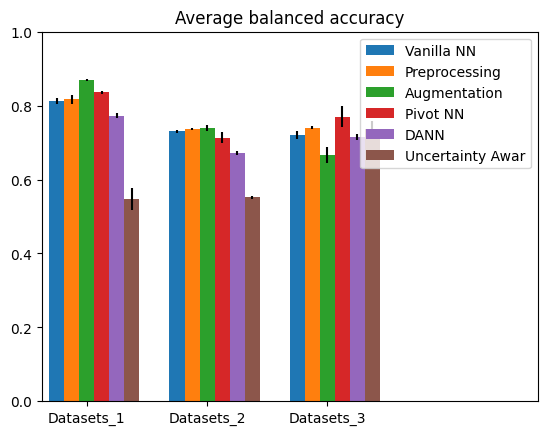

In [65]:
visualize_bar_plots(df_means_over_runs,df_stds_over_runs)

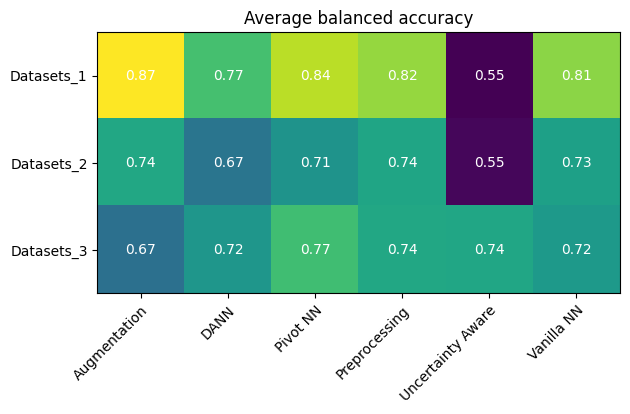

In [66]:
visualize_heat_map(df_means_over_runs)

Same without uncertainty aware method

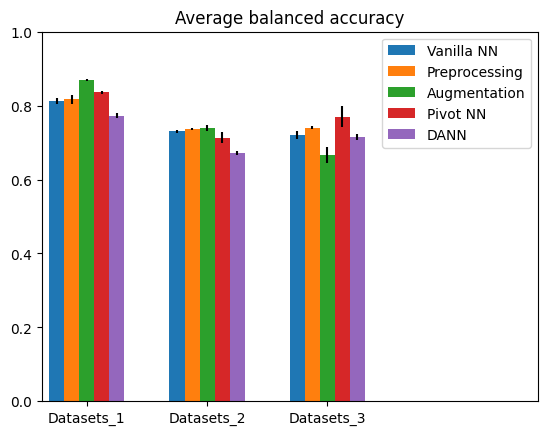

In [67]:
visualize_bar_plots(df_means_over_runs.drop("Uncertainty Aware"),df_stds_over_runs.drop("Uncertainty Aware"))

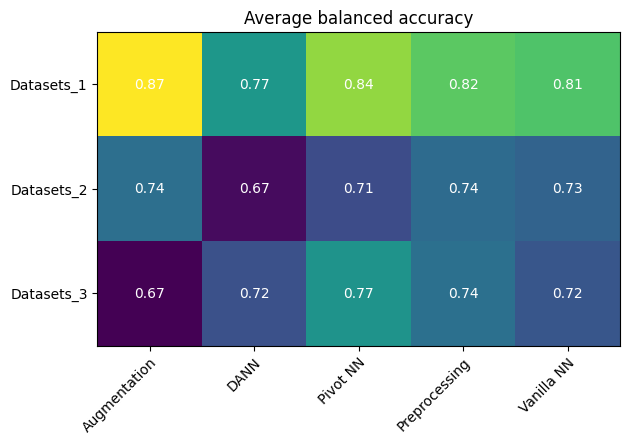

In [68]:
visualize_heat_map(df_means_over_runs.drop("Uncertainty Aware"))

## 4.2 - Results over one run

Knowing that the results over several runs are stable, we can see how much the results of the models vary on each kind of datasets. We consider only one run. For each of the 6 methods and each of the 3 sets of datasets, we average the balanced accuracy obtained over the 12 datasets on this run. Same for standard deviation.

In [57]:
outputs_list = runs_list[0]
df_means, df_stds = build_dataframes (outputs_list)

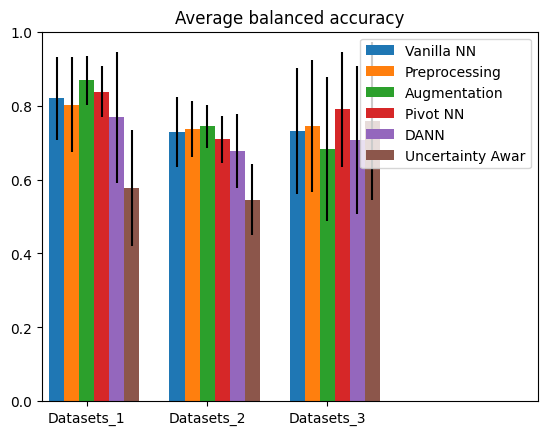

In [69]:
visualize_bar_plots(df_means,df_stds)

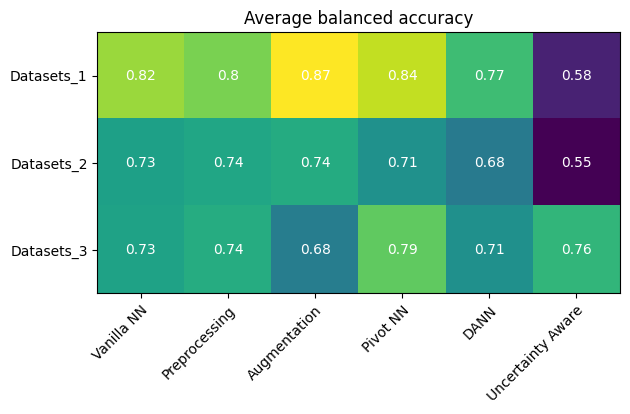

In [70]:
visualize_heat_map (df_means)

Same without uncertainty aware method

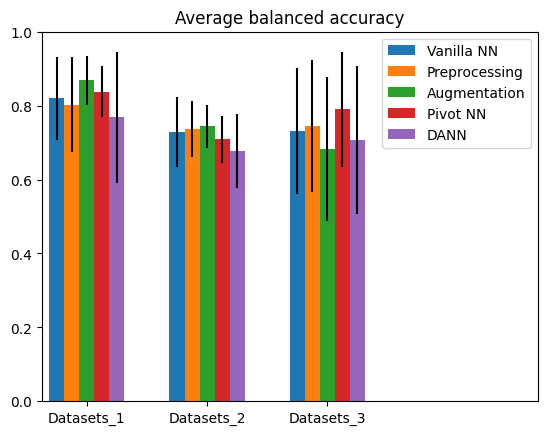

In [71]:
visualize_bar_plots(df_means.drop("Uncertainty Aware"),df_stds.drop("Uncertainty Aware"))

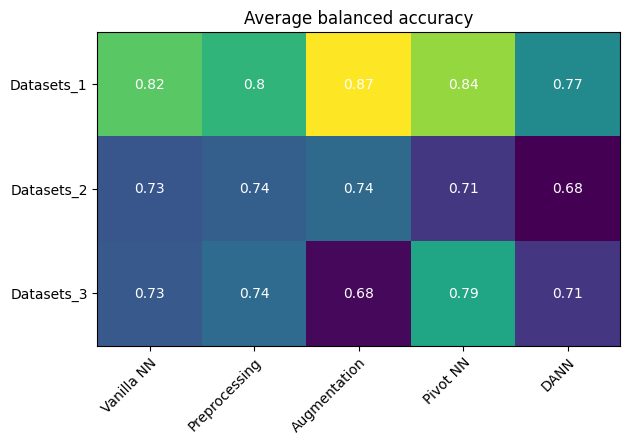

In [72]:
visualize_heat_map (df_means.drop("Uncertainty Aware"))